# Goal

Test transforms

Thanks to: fastAI, FAIMED3D
-  https://github.com/kbressem/faimed3d/blob/main/faimed3d/augment.py#L515
-  https://github.com/fastai/fastai/blob/master/fastai/vision/augment.py#L21

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from helpers.preprocess import mask2bbox
from helpers.viz import get_mid_idx

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import colors
bin_cmap2  = colors.ListedColormap(['white', 'yellow'])

def imshows(ims):
    nrow = len(ims)
    ncol = 6
    
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        im = im_dict["image"].detach().squeeze().cpu().numpy()
        label = im_dict["label"].detach().squeeze().cpu().numpy()
        fname = im_dict["fname"]
        
        # get bbox
        bbox = mask2bbox(label)
        mids = get_mid_idx(bbox)
        for axis_idx in range(3):
            slice_idx = mids[axis_idx]

            # plot image 0-2
            ax  = axes[i, 0+axis_idx]
            ax.set_title(f"{i}. Slice {slice_idx} (Axis {axis_idx})")
            ax.imshow(np.rot90(np.take(im, slice_idx, axis=axis_idx)), cmap=plt.cm.gray)
            ax.imshow(np.rot90(np.take(label, slice_idx, axis=axis_idx)), alpha=0.2, cmap=bin_cmap2)
            ax.axis("off")
                
            # plot labels 3-5
            ax        = axes[i, 3+axis_idx]
            ax.axis("off")
            im_show = ax.imshow(np.rot90(np.take(label, slice_idx, axis=axis_idx)))
            fig.colorbar(im_show, ax=ax)
            
        # print fname
        axes[i,3].set_title(f"{fname}")
        

# Get data

In [3]:
from helpers.items_constants import *

Full lbl items: 335
Removed 2 weird, new total lbl items: 333
train, valid, test 201 66 66 total 333
Cross label items:  418
All label items:  751 (abide (333) + cross_lbl (418))
Test label items:  484 (test (66) + cross_lbl (418))


In [4]:
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    CenterSpatialCropd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAdjustContrastd,
    RandAffined,
    RandFlipd,
    RandGaussianNoised,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    NormalizeIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

In [5]:
import re
def get_folder_name(f): return re.search("\/([\d+]{5})\/", f).groups(0)[0]

In [6]:
import numpy as np
import torch

#full_res = (128, 128, 128)
full_res = (96, 96, 96)

keys = ["image", "label"]
p = 1.0
pixdim = 1.5
pixdim = (1.5 for _ in range(3))

def get_train_transforms(pixdim, full_res):
    train_transforms = Compose(
            [
                LoadImaged(keys),
                Spacingd(keys, pixdim=pixdim, mode=("bilinear", "nearest")),
                NormalizeIntensityd(keys[0], nonzero=True, channel_wise=False),

                RandScaleIntensityd(keys[0], factors=0.1, prob=p),
                RandShiftIntensityd(keys[0], offsets=0.1, prob=p),
                RandGaussianNoised(keys[0], prob=p, std=0.01), # prob = 0.15
                RandAdjustContrastd(keys[0], prob=p, gamma=(0.5, 2.)),

                RandFlipd(keys, spatial_axis=0, prob=p),
                RandFlipd(keys, spatial_axis=1, prob=p),
    #             RandFlipd(keys, spatial_axis=2, prob=p),

                AddChanneld(keys),
                RandAffined(keys, mode=("bilinear", "nearest"), prob=p, spatial_size = (192, 192, 192),
                    rotate_range=(np.pi/8,np.pi/8,np.pi/8), 
                    scale_range = (0.1, 0.1, 0.1),
                    translate_range = (15, 15, 15),
                    padding_mode = "border",
                    device=torch.device('cuda:0')
                ),
                RandSpatialCropd(keys, roi_size = full_res, max_roi_size=None, random_center=False, random_size=False),
                ToTensord(keys=keys),
                #UndoDict(),
            ]
        )
    
    return train_transforms

In [7]:
# keys = ["image", "label"]
# p = 0.5

#     train_transforms = Compose(
#         [
#             LoadImaged(keys),
#             Spacingd(keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
#             NormalizeIntensityd(keys[0], nonzero=True, channel_wise=False),
                        
#             RandScaleIntensityd(keys[0], factors=0.1, prob=p),
#             RandShiftIntensityd(keys[0], offsets=0.1, prob=p),
#             RandGaussianNoised(keys[0], prob=p, std=0.01), # prob = 0.15
#             RandAdjustContrastd(keys[0], prob=p, gamma=(0.5, 2.)),
            
#             RandFlipd(keys, spatial_axis=0, prob=p),
#             RandFlipd(keys, spatial_axis=1, prob=p),
# #             RandFlipd(keys, spatial_axis=2, prob=p),
            
#             AddChanneld(keys),
#             RandAffined(keys, mode=("bilinear", "nearest"), prob=p, spatial_size = (192, 192, 192),
#                 rotate_range=(np.pi/8,np.pi/8,np.pi/8), 
#                 scale_range = (0.1, 0.1, 0.1),
#                 translate_range = (15, 15, 15),
#                 padding_mode = "zeros",
#                 device=torch.device('cuda:0')
#             ),
#             RandSpatialCropd(keys, roi_size = full_res, max_roi_size=None, random_center=False, random_size=False),
#             ToTensord(keys=keys),
#             UndoDict(),
#         ]
#     )

In [22]:
from helpers.transforms import get_train_valid_transforms as whaa

whaa_tfms,_ = whaa(pixdim=(1.5,1.5,1.5), full_res=(96,96,96))

In [24]:
# test on one
train_files = getd(abide_lbl_items)
file = train_files[0]

to_imshow = []

for _ in range(10):
    data = whaa_tfms(file)
    to_imshow.append({"image": data[0], "label": data[1], "fname": get_folder_name(file["image"])})
    

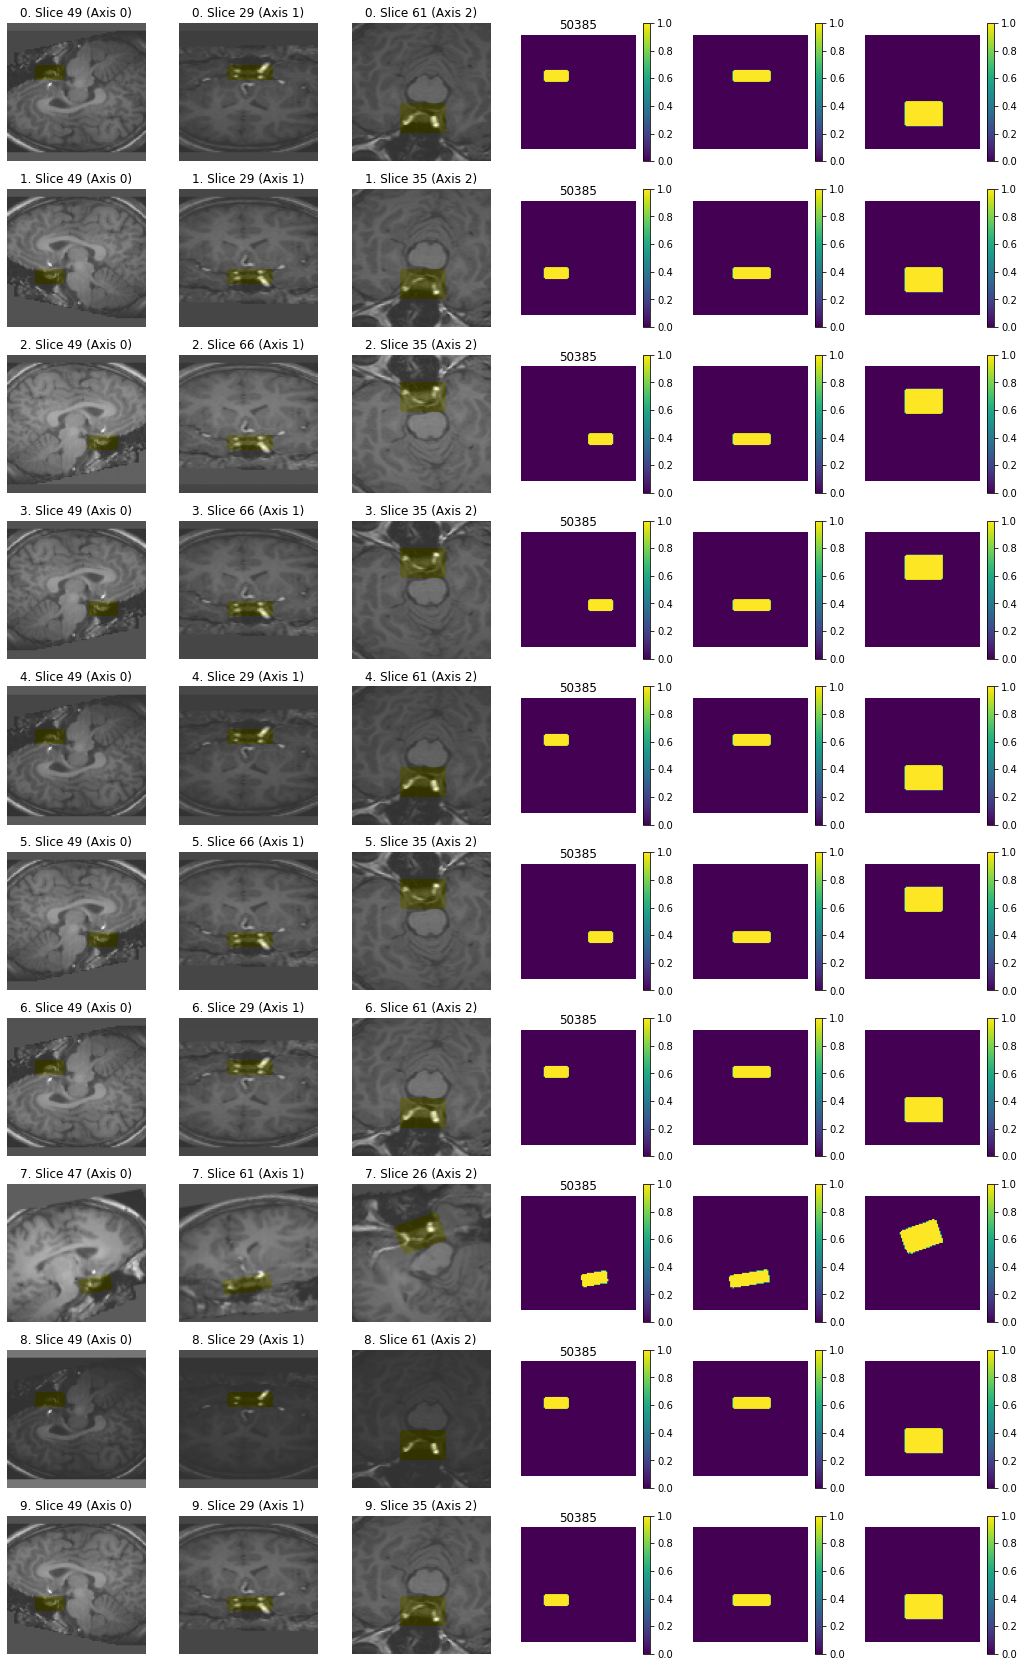

In [25]:
imshows(to_imshow)

In [19]:
# test on one
train_files = getd(abide_lbl_items)
file = train_files[0]

to_imshow = []

for _ in range(10):
    train_transforms = get_train_transforms(pixdim=1.5, full_res=(96,96,96))
    data = train_transforms(file)
    to_imshow.append({"image": data["image"], "label": data["label"], "fname": get_folder_name(file["image"])})
    

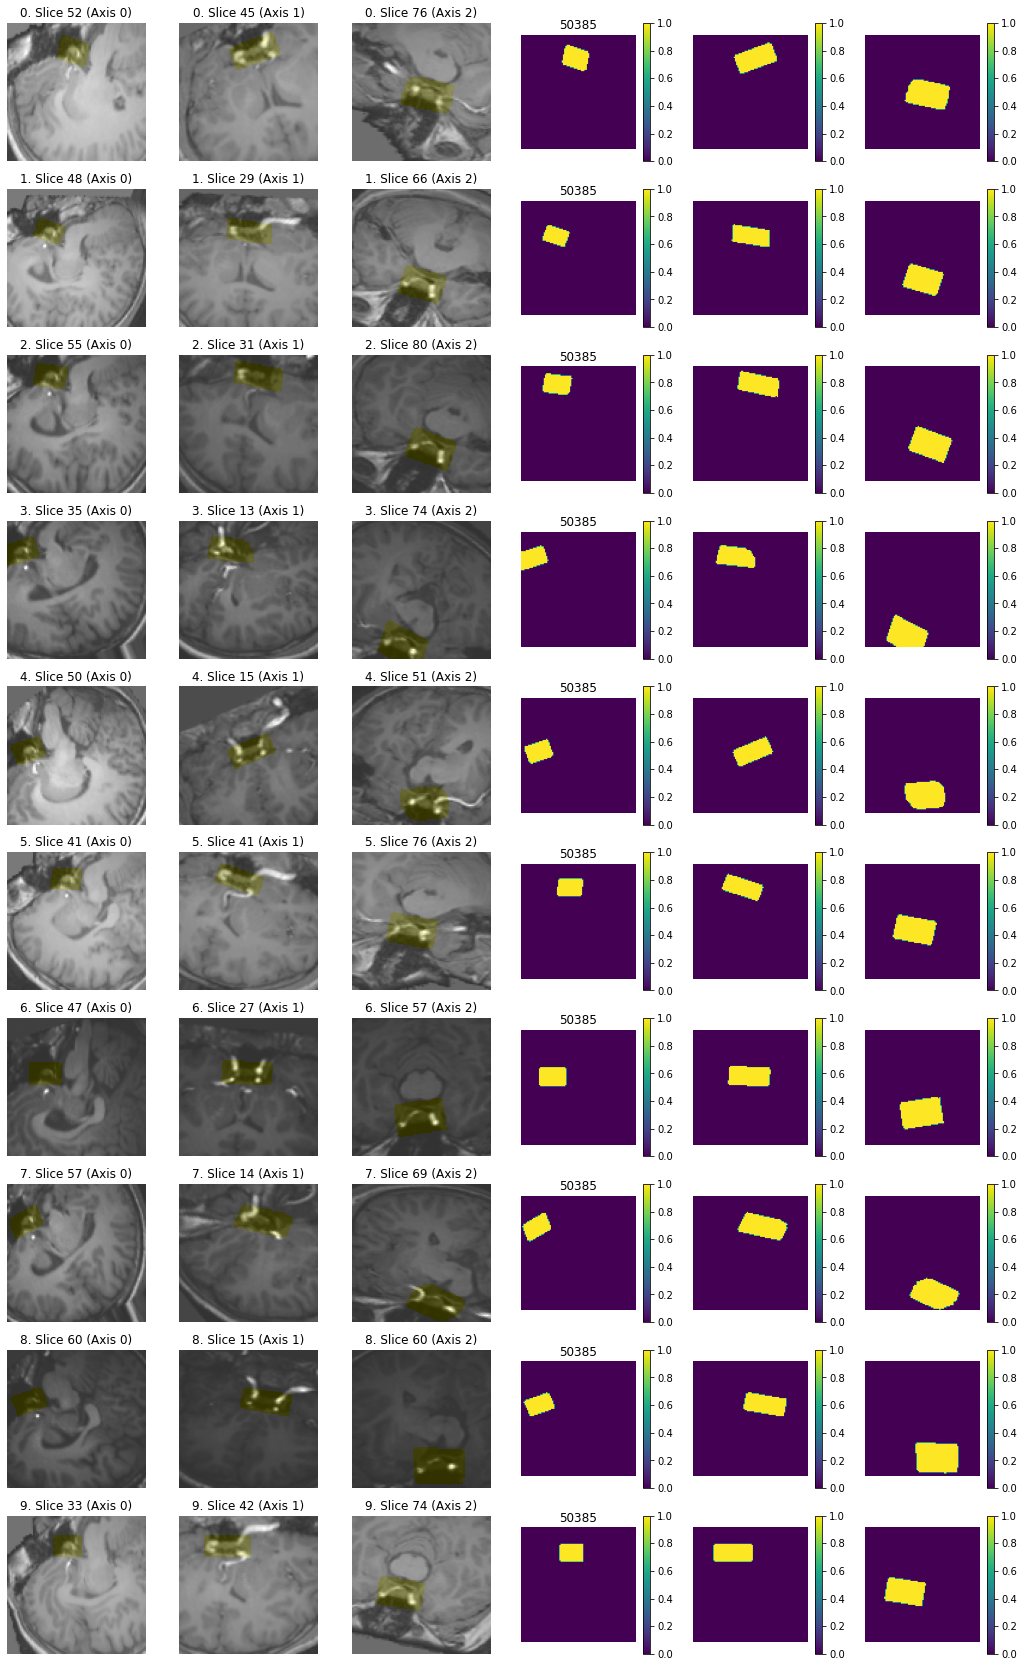

In [20]:
imshows(to_imshow)

In [55]:
all_files = getd(all_test_lbl_items)
tofind = f"{data_src}/PitMRdata/ICMB/ICBM/UTHC_1091/MPRAGE_T1_AX_0.8_mm_TI-787/2008-11-19_12_51_58.0/S61555/las_corrected_n4.nii"
found = [item for item in all_files if item["image"]==tofind][0]

In [56]:
to_imshow = []

import re
def get_folder_name_icmb(f): return re.search("(ICBM\/.*\/)", f).groups(0)[0]

for _ in range(10):
    train_transforms = get_train_transforms(pixdim=1.5, full_res=(96,96,96))
    data = train_transforms(file)
    to_imshow.append({"image": data["image"], "label": data["label"], "fname": get_folder_name(file["image"])})
    

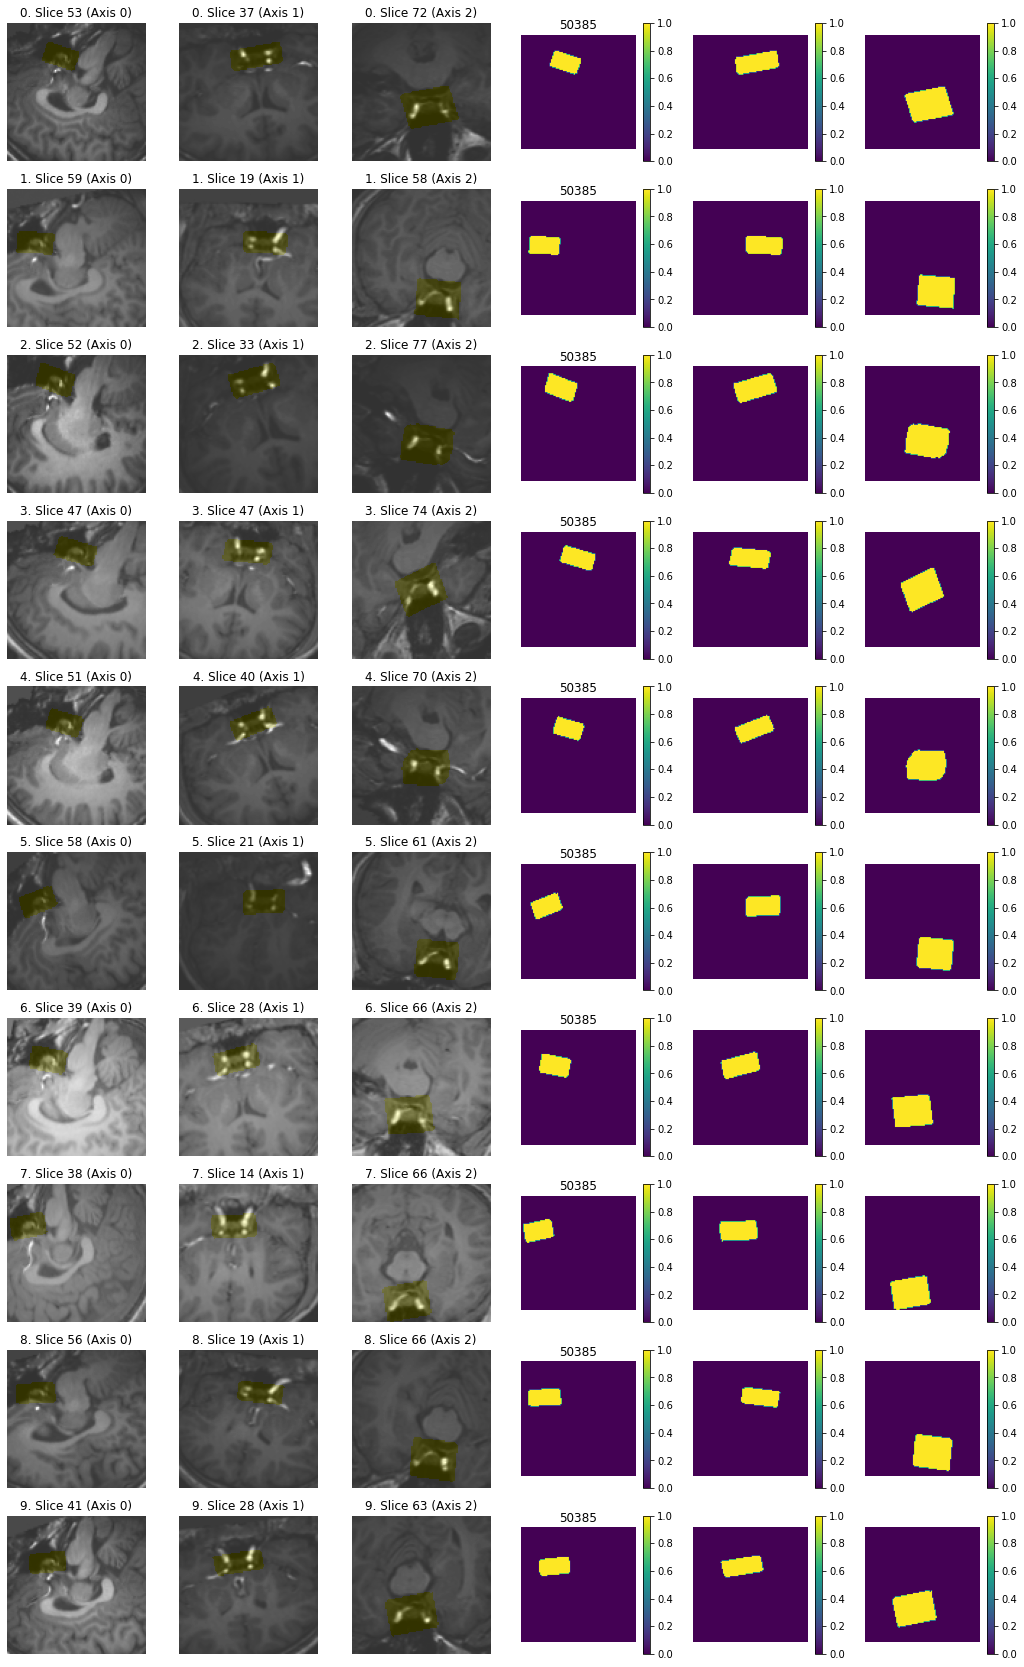

In [57]:
import matplotlib.pyplot as plt
imshows(to_imshow)

In [58]:
train_files = getd(abide_lbl_items)
to_imshow = []

# multiple transforms on one file
file = train_files[0]
for _ in range(4):
    data = train_transforms(file)
    to_imshow.append({"image": data["image"], "label": data["label"], "fname": get_folder_name(file["image"])})
    

In [49]:
from helpers.preprocess import *
from helpers.viz import *

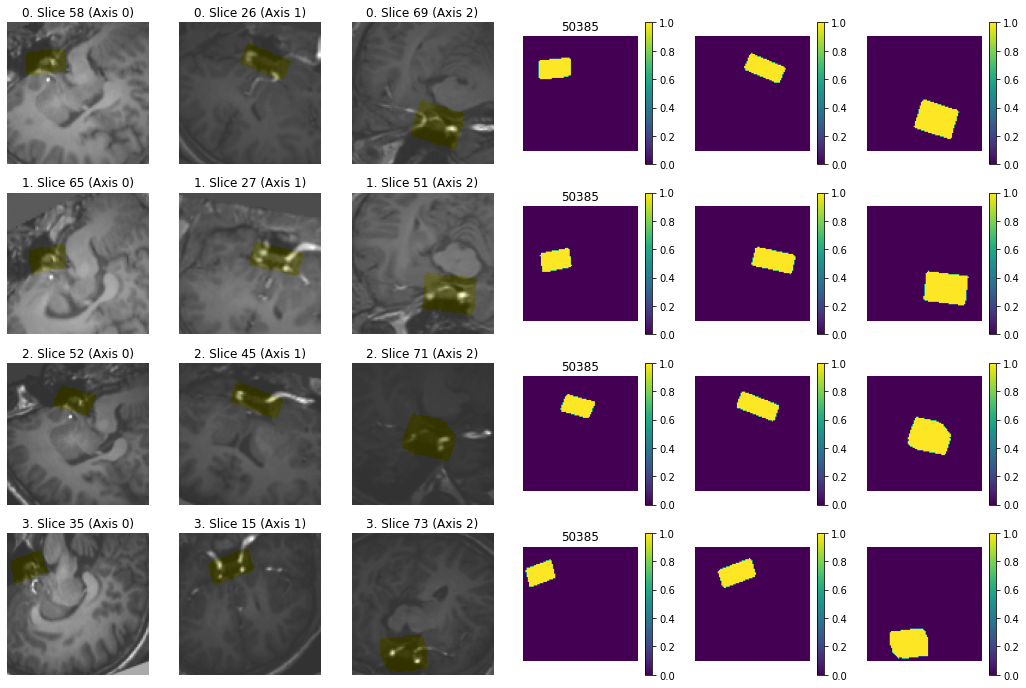

In [50]:
import matplotlib.pyplot as plt
imshows(to_imshow)

In [38]:
train_files = getd(abide_lbl_items)
to_imshow = []

# multiple transforms on one file
# file = train_files[0]
# for _ in range(5):
#     data = train_transforms(file)
#     to_imshow.append({"image": data["image"], "label": data["label"]})
    
#multiple files
for file in np.random.choice(train_files, size=20, replace=False):
    data = train_transforms(file)
    to_imshow.append({"image": data["image"], "label": data["label"], "fname": get_folder_name(file["image"])})
    

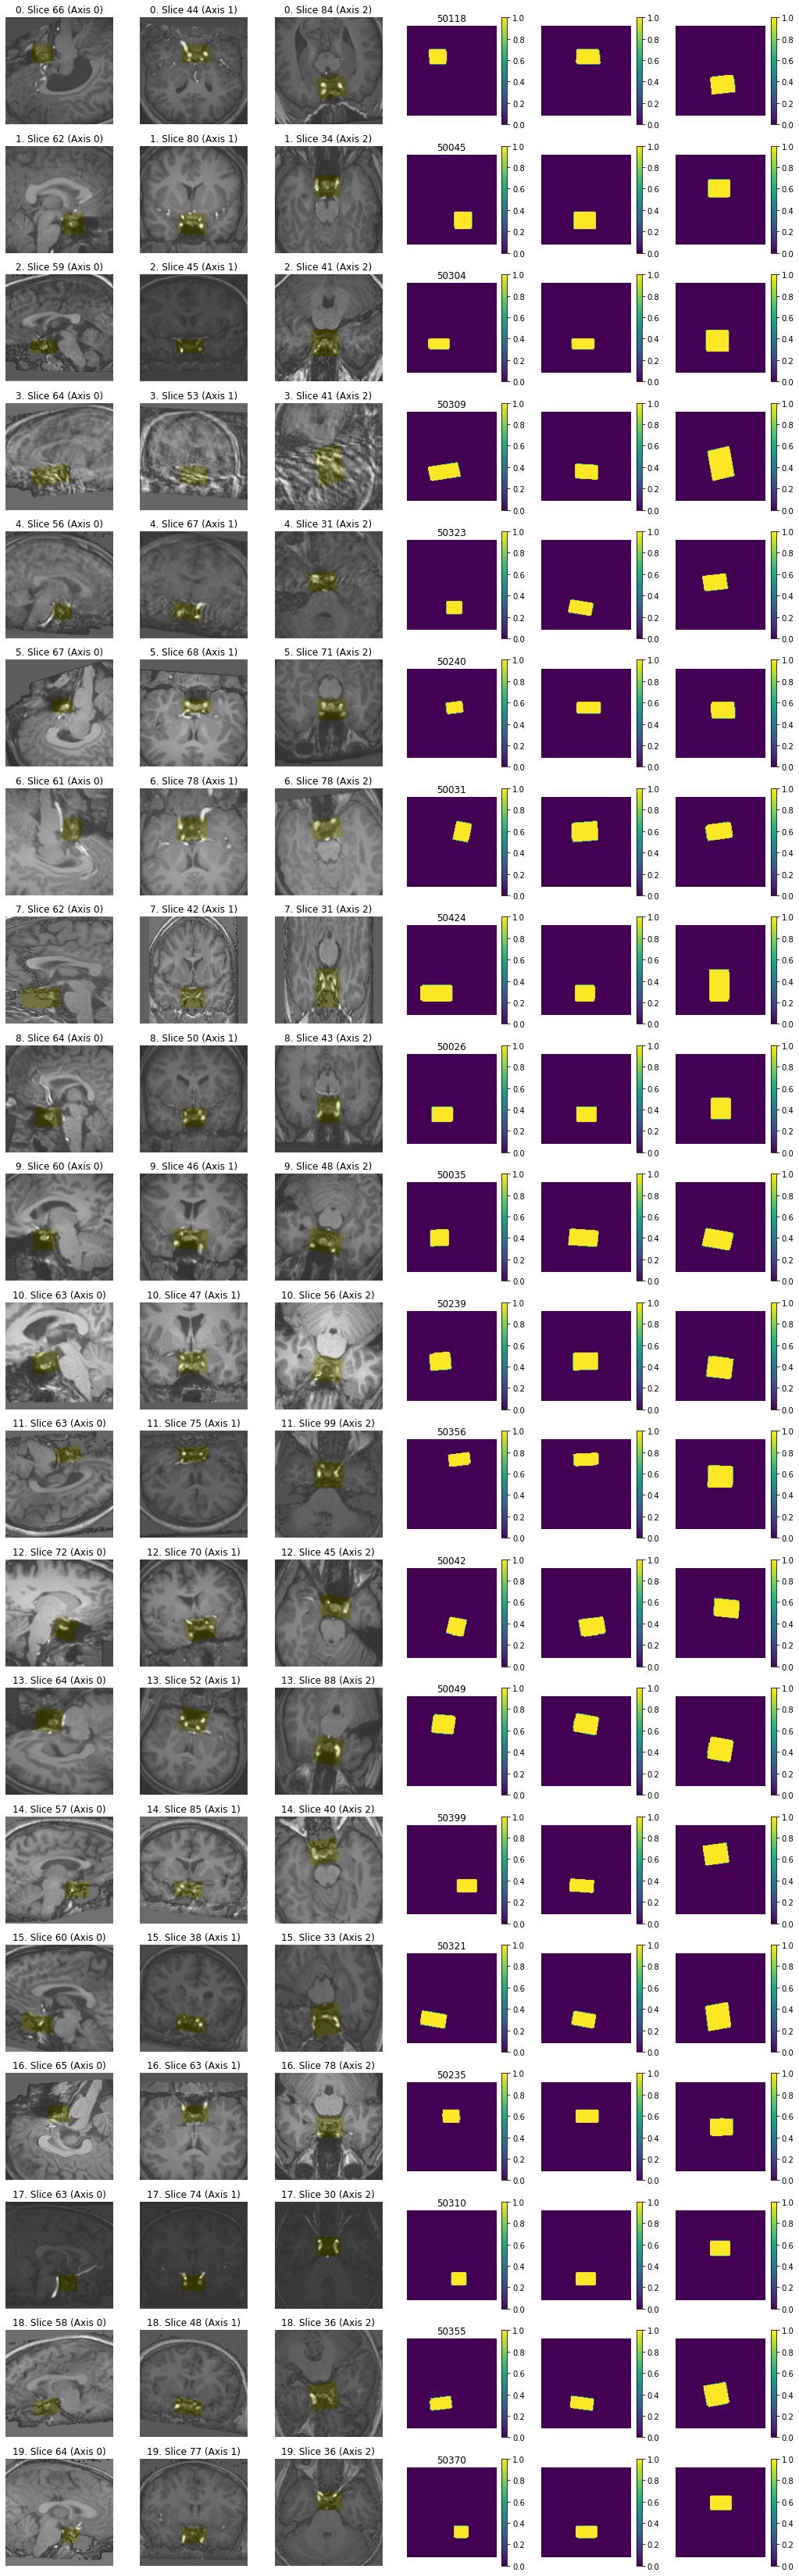

In [39]:
imshows(to_imshow)

In [96]:
#multiple files
to_imshow = []
for file in train_files:
    data = train_transforms(file)
    to_imshow.append({"image": data["image"], "label": data["label"], "fname": get_folder_name(file["image"])})
imshows(to_imshow)

KeyboardInterrupt: 

ValueError: Image size of 1296x71928 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1296x71928 with 2443 Axes>

In [65]:
# from helpers.transforms import UndoDict, get_train_valid_transforms
# from monai.data import DataLoader, Dataset, CacheDataset

# full_res = (128, 128, 128)
# train_tfms, valid_tfms = get_train_valid_transforms(full_res)

# check_ds     = Dataset(data=getd(abide_lbl_items), transform=train_tfms)
# check_loader = DataLoader(check_ds, batch_size=10)

# orig_batch = first(check_loader)
# orig_xb, orig_yb = UndoDict(image_key="image", label_key="label")(orig_batch)
# print(orig_xb.size(), orig_yb.size())